In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import popoff
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import copy
from linear_model import PoolAcrossSessions
from scipy.stats import linregress
from scipy import stats
from statsmodels.stats import multitest
from Session import SessionLite, build_flu_array_single
from IPython.core.debugger import Pdb
ipdb = Pdb()

In [22]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
'#3A9DEF',
'pink',
'grey',
'black',
]

figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

In [23]:
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets, remove_toosoon=True,
                         subsample_sessions=False)
lm = pas.linear_models[0]
pas.sessions

long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time


{3: instance Mouse J064, run 10 of Session class,
 4: instance Mouse J064, run 11 of Session class,
 5: instance Mouse J064, run 14 of Session class,
 6: instance Mouse RL070, run 28 of Session class,
 7: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J063, run 9 of Session class,
 1: instance Mouse J065, run 11 of Session class}

In [116]:
print(pas.plot_string(is_plot=False))

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse J064, run 11', 'Mouse J064, run 14', 'Mouse RL070, run 28', 'Mouse RL070, run 29', 'Mouse J063, run 9', 'Mouse J065, run 11']
pre-frames spans -1.97 to -0.07 inclusive
post-frames spans 0.83 to 8.0 inclusive


In [127]:
def get_sig_pass(session, fdr_rate=0.1, ps_type=1, subset=[150], outcome='all',
                 cells='all', direction='both'):
    
    
    behaviour_trials = session.behaviour_trials
    trials_use = np.isin(session.trial_subsets, subset)
        
    if outcome != 'all':
        trials_use = np.logical_and(trials_use, session.outcome==outcome)
        
    if outcome =='spont_rew':
        arr = session.pre_rew_trials
    else:
        arr = behaviour_trials[:, trials_use, :]
    
#     if cells == 's1':
#         arr = arr[session.s1_bool, :, :]
#     elif cells == 's2':
#         arr = arr[session.s2_bool, :, :]
        
    
#     pre_array = prepare_population(copy.deepcopy(arr), pre_frames)
#     post_array = prepare_population(copy.deepcopy(arr), post_frames)

    pre_array = np.mean(arr[:, :, lm.pre], 2)
    post_array = np.mean(arr[:, :, lm.post], 2)
    
#     if outcome != 'spont_rew' and mask_targets==True:  # This can be made less shit
#         p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)
#                  if not pre.mask.all()]
#     else:
    p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        
    p_vals = np.array(p_vals)

    sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)
    
    positive = np.mean(post_array, 1) - np.mean(pre_array, 1) > 0
    
    if direction == 'positive':
        sig_cells = np.logical_and(sig_cells, positive)
    elif direction == 'negative': 
        sig_cells = np.logical_and(sig_cells, ~positive)
    
    return sig_cells

In [111]:
def post_pre_subtract(arr, lm):
    
    # Mean across frames
    post_mean = np.mean(arr[:, :, lm.frames_map['post']], 2)
    pre_mean = np.mean(arr[:, :, lm.frames_map['pre']], 2)
    
    subbed = post_mean - pre_mean
    
    # Sum delta across cells
    return np.sum(subbed, 0)

In [134]:
def transfer_function(lm, region, outcome, select_responders=True, exclude_easy=False):
    
    region_bool = lm.region_map[region]
    outcome_bool = lm.session.outcome == outcome
    if exclude_easy:  # This will currently break for fp and cr
        outcome_bool = np.logical_and(outcome_bool, lm.session.photostim==1)
    
    flu = lm.flu[:, outcome_bool, :]
    
    is_target = lm.session.is_target[:, :, lm.session.frames_use]
    is_target = is_target[:, outcome_bool, :]
    
    assert flu.shape == is_target.shape
    
    
    targets = np.ma.array(flu, mask=~is_target)
    
    if not select_responders:
        non_targets = np.ma.array(flu[region_bool, :, :], mask=is_target[region_bool, :, :])
    else:
        responders = get_sig_pass(lm.session, 0.1, subset=[20,30,40,50], cells=region, 
                                  direction='positive', outcome=outcome)
        
        cells_keep = np.logical_and(responders, region_bool)
        non_targets = flu[cells_keep, :, :]
    
    input_ = post_pre_subtract(targets, lm)
    output_ = post_pre_subtract(non_targets, lm)
    
    return input_, output_

In [135]:
def whole_region_transfer(lm, outcome, exclude_easy=True):
    
    outcome_bool = lm.session.outcome == outcome
    
    if exclude_easy:
        outcome_bool = np.logical_and(outcome_bool, lm.session.photostim==1)
    
    flu = lm.flu[:, outcome_bool, :]
    
    input_ = post_pre_subtract(flu[lm.region_map['s1'], :, :], lm)
    output_ = post_pre_subtract(flu[lm.region_map['s2'], :, :], lm)
    
    return input_, output_

In [136]:
def multisession_transfer_function(pas, region, outcome, whole_region=False):
    
    input_ = []
    output_ = []
    for lm in pas.linear_models:
        if whole_region:
            io = whole_region_transfer(lm, outcome)
        else:
            io = transfer_function(lm, region, outcome)
        input_.append(io[0])
        output_.append(io[1])
        
    input_ = np.concatenate(input_)
    output_ = np.concatenate(output_)
    
    if outcome == 'hit':
        color = COLORS[0]
    elif outcome == 'miss':
        color = COLORS[1]
    else:
        color = 'black'
        
    plt.plot(input_, output_, '.', color=color)
    
    slope, intercept, r_value, p_value, std_err = linregress(input_, output_)
    xlims = plt.gca().get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(x, slope*x + intercept, color=color)
    
#     plt.ylim(-0.2, 0.3)
#     plt.xlim(-0.3, 0.3)
    if not whole_region:
        title_str = f'{region.upper()}, {outcome} trials\n Slope = {round(slope, 2)}, '\
                    f'R^2 = {round(r_value, 2)} p = {p_value:.2e}'
    else: 
        title_str = f'{outcome} trials\n Slope = {round(slope, 2)}, '\
                    f'R^2 = {round(r_value, 2)} p = {p_value:.2e}'
    
    plt.title(outcome.capitalize(), fontsize=30)

    plt.text(0.1, 0, f'Slope = {round(slope, 2)}', fontsize=20)

    if not whole_region:
        plt.xlabel('INPUT (Delta Activity targets)')
        if outcome != 'miss': plt.ylabel('OUTPUT (Delta Activity non-targets)')
    else:
        plt.xlabel('INPUT (Delta activity all cells S1)')
        if outcome != 'miss': plt.ylabel('OUTPUT (Delta Activity all cells S2)')


[False False False False False False  True  True False False False  True
 False False False False False False False False  True False False False
  True False False False False  True False False False False  True False
 False False False False False False False False False False False  True
 False  True False False  True False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False  True  True False False  True
 False False False  True False False False False False  True False False
  True False  True False False False False False False False False False
 False False  True False False False False False False False  True False
  True False False  True False False False  True  T

[False False False False False False  True False False False False False
 False False False False  True False False  True  True False False False
 False  True False False False  True  True  True  True False False False
  True False False False False False False False False False  True  True
 False False False False  True False False False  True False False  True
  True False False  True False False False False False  True False False
 False  True False False  True  True False  True False False False False
  True False False False  True  True False  True False  True False False
 False False False False False False  True False False False False False
 False False False False  True False False False False  True False False
 False False False False False False  True  True  True False False False
 False False  True False False  True False  True  True False False False
 False False False False False False False False False  True False False
 False False False False False  True  True False Fa

[False False False False False False False False False False False  True
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
  True False  True False False False False  True  True False False False
 False  True False False False False False  True False False False False
 False False False False False False  True False  True  True False False
 False  True False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False False False  True False False False  True False
 False False False False False False False False  True False  True False
 False False False  True False False False False False False False False
 False False False  True False False  True False  True  True False  True
  True False False False False  True False False  True False False  True
 False False False  True False  True False  True Fa

[False False False False False  True False False False False False False
 False False False  True False False  True  True False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False  True False  True False False False False False False False False
 False False False False False False False False False  True False False
 False False False  True False False False False False False False False
  True False False False  True False  True  True False False False  True
 False False  True False False  True False False False False False False
 False  True False False False False  True False Fa

[False False False  True False False  True False False False False False
 False False  True False False  True False  True False False  True  True
 False False False False  True False  True False False False False False
 False False False False  True False False  True False False False False
  True  True False False  True False False False False False  True False
 False False False False False False False False False  True False False
 False False  True  True False False False False False False False False
 False False False False False  True False  True False False False False
  True False False False False False  True False  True False False False
 False False  True False  True False  True  True False False False False
 False False  True False False  True False False False False  True False
  True False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

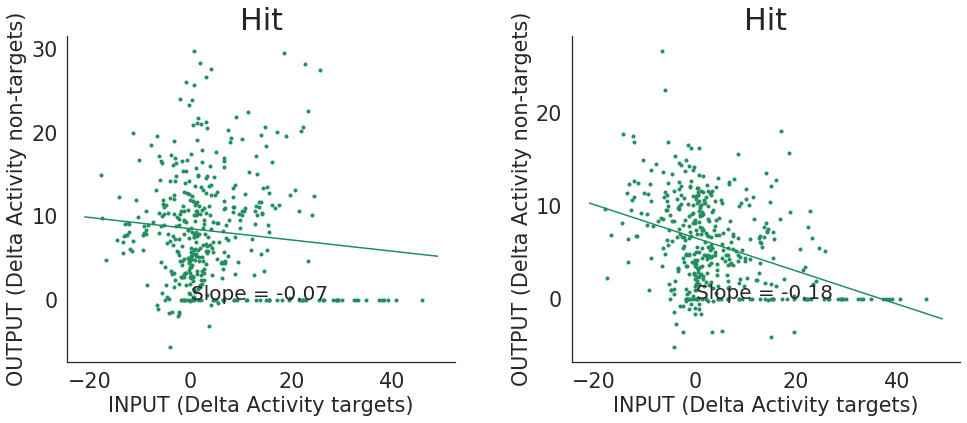

In [137]:
outcome = 'hit'

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
multisession_transfer_function(pas, 's1', outcome=outcome, whole_region=False)
plt.subplot(1,2,2)
multisession_transfer_function(pas, 's2', outcome=outcome, whole_region=False)
plt.subplots_adjust(wspace=0.3)

In [60]:
def prepare_population(arr, frames, mean=True):
    
    arr_frames = arr[:, :, range(*frames)] 
    if mean:
        return np.mean(arr_frames, 2)
    else:
        return np.reshape(arr_frames, (arr_frames.shape[0], arr_frames.shape[1] * arr_frames.shape[2]))

In [124]:
get_sig_pass(lm.session, subset=[20,30,40,50], outcome='hit')

array([False,  True, False, False, False, False,  True,  True, False,
       False,  True,  True, False,  True, False, False,  True, False,
       False, False,  True, False,  True, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
       False, False, False, False,  True,  True, False,  True, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False, False, False,  True, False,  True,
       False,  True,

AssertionError: 

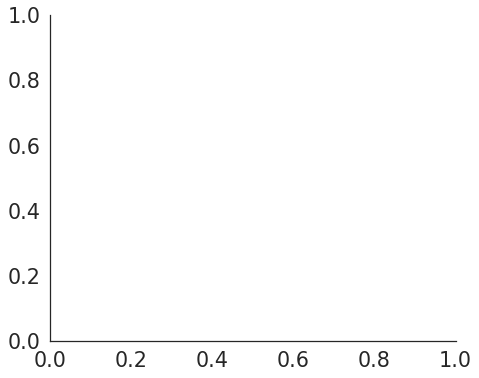

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
multisession_transfer_function(pas, 's2', outcome='hit', whole_region=False)
plt.subplot(1,2,2)
multisession_transfer_function(pas, 's2', outcome='miss', whole_region=False)

In [15]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [20]:
def session_flu(lm, region, outcome, frames, n_cells, subtract_baseline=True):

    # Select region and trial outcomes
    if outcome != 'pre_reward':
        flu = lm.flu
        outcome_bool = lm.session.outcome == outcome
        
        if outcome in ['hit', 'miss']:
            n_stimmed_bool = np.isin(lm.session.trial_subsets, n_cells)
            outcome_bool = np.logical_and(outcome_bool, n_stimmed_bool)
        
        flu = flu[:, outcome_bool, :]
    else:
        flu = lm.pre_flu
    
    flu = flu[lm.region_map[region], :, :]
    # Mean across cells
    flu = np.mean(flu, 0)
    
    if subtract_baseline:
        flu = baseline_subtraction(flu, lm)
        
    # Select desired frames
    if frames != 'all':
        flu = flu[:, lm.frames_map[frames]]
    
    return flu

In [53]:
def multisesssion_flu(pas, region, outcome, frames, n_cells, stack='all-trials'):
    
    if outcome == 'hit':
        color = COLORS[0]
    elif outcome == 'miss':
        color = COLORS[1]
    elif outcome == 'pre_reward':
        color = COLORS[2]
    elif outcome == 'fp':
        color = COLORS[3]
    elif outcome == 'cr':
        color = COLORS[4]
        
    flu = []
    for lm in pas.linear_models:
        sf = session_flu(lm, region=region, outcome=outcome, frames=frames, 
                         n_cells=n_cells)
        if stack == 'all-trials':
            flu.append(sf)  # stack every trial from every session in a big array
        else:
            flu.append(np.mean(sf, 0))  # stack the session mean into a big array
    
    flu = np.vstack(flu)
    mean_flu = np.mean(flu, 0)
    std_flu = np.std(flu, 0) / flu.shape[0]  # This is too small
    
    if outcome != 'pre_reward':
        # Remove the artifact
        mean_flu[np.logical_not(lm.frames_map['all'])] = np.nan
        label = outcome.capitalize()
    else:
        label = 'Spontaneous\nReward'
    
    plt.plot(mean_flu, color=color, label=label)
    plt.fill_between(np.arange(len(mean_flu)), mean_flu+std_flu, mean_flu-std_flu, color=color)
    
    times_axis = np.logical_and(np.floor(lm.times_use) == np.ceil(lm.times_use), 
                                np.mod(lm.times_use, 2)==0)
    
#     times_where = np.where(np.isin(times_use, times_on_axis))[0]
    plt.xticks(np.where(times_axis)[0], lm.times_use[times_axis])
    
    plt.xlabel('time (seconds)', fontsize=28)
    plt.axhline(0, ls=':', color='grey')

    if region != 's2': plt.ylabel(r'$\Delta$F/F', fontsize=28)

In [58]:
def s1_s2_plot(pas, n_cells):

    plt.figure(figsize=(16,6))
    frames = 'all'
    tts_plot = ['hit', 'miss', 'fp', 'cr','pre_reward']
    tts_plot = ['hit', 'miss']
    tts_plot = ['fp', 'cr', 'pre_reward']
    
    ylims = (-0.05, 0.05)

    plt.subplot(1,2,1)
    plt.suptitle(f'Number of cells stimmed = {n_cells}', fontsize=25)
    region = 's1'
    stack = 'all-trials'
    for tt in tts_plot:
        multisesssion_flu(pas, region=region, outcome=tt, frames=frames, n_cells=n_cells,
                          stack=stack)
    plt.title(region.upper(), fontsize=18)
    plt.ylim(ylims)


    plt.subplot(1,2,2)
    region = 's2'
    for tt in tts_plot:
        multisesssion_flu(pas, region=region, outcome=tt, frames=frames, n_cells=n_cells,
                          stack=stack)

    plt.title(region.upper(), fontsize=18)
    leg = plt.legend(bbox_to_anchor=[1, 0.5])
    lines = leg.get_lines()
    _ = [line.set_linewidth(10) for line in lines]
    plt.ylim(ylims)

    name_plot  = '-'.join(tts_plot)
    plt.savefig(os.path.join(figure_path, f'traces{name_plot}.pdf'), bbox_inches="tight")

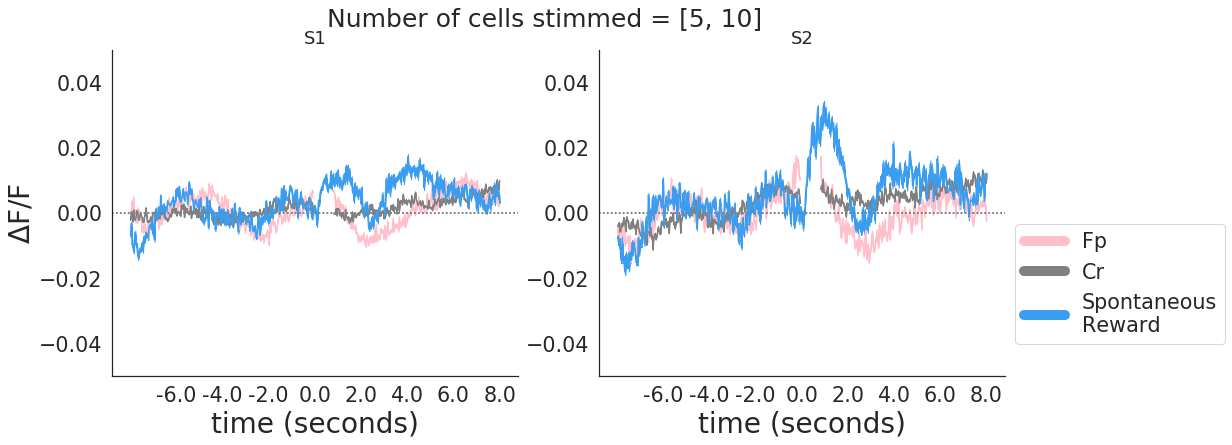

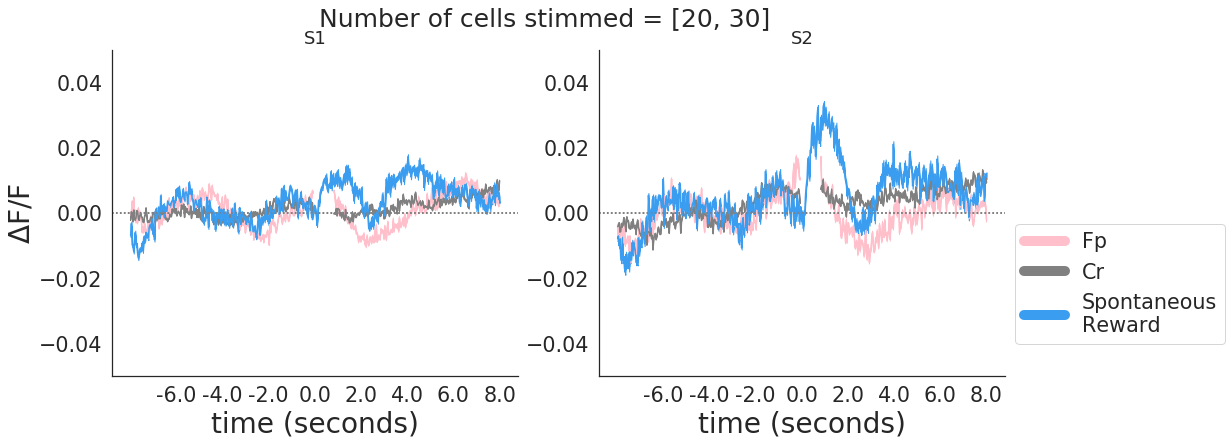

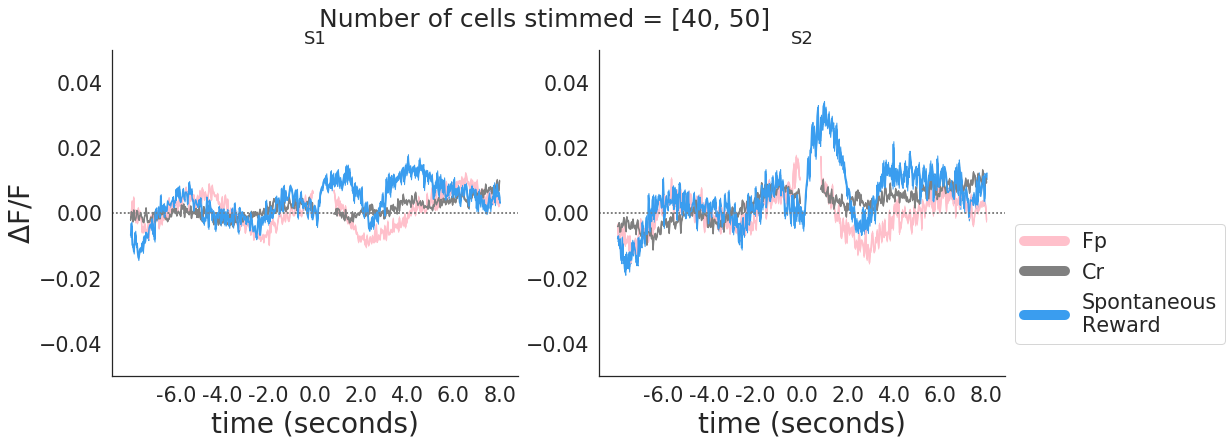

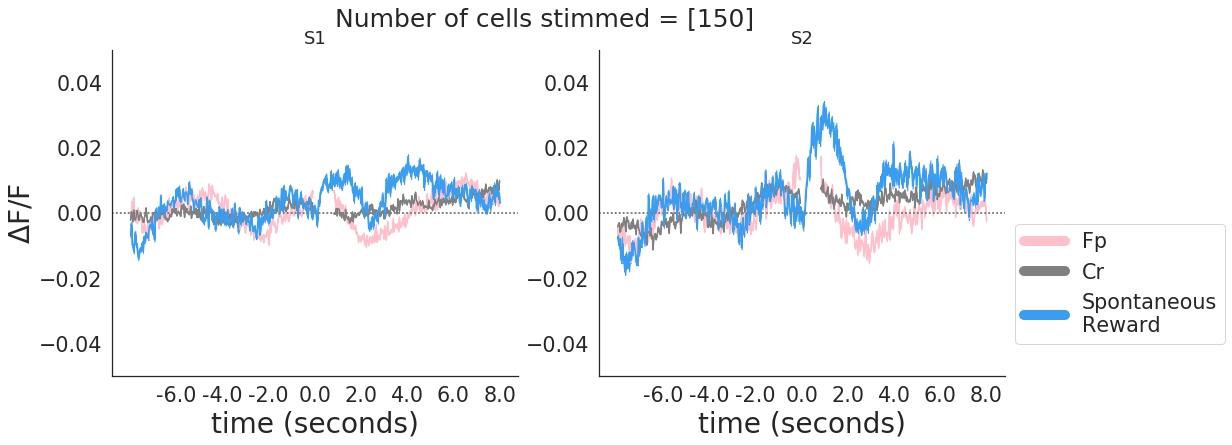

In [59]:
for n_cells in [[5,10], [20,30], [40,50], [150]]:
    s1_s2_plot(pas, n_cells)

In [76]:
fs = []
for lm in pas.linear_models:
    session = lm.session
    cells = lm.region_map['s2']
    trials = session.outcome == 'hit'
    f = session.behaviour_trials[cells, :, :]
    f = f[:, trials, :]
    f = np.mean(f,0)
    print(f.shape)
    fs.append(f)
    
fs = np.vstack(fs)


(49, 360)
(56, 360)
(63, 360)
(46, 360)
(72, 360)
(66, 360)
(68, 360)


(-0.03, 0.02)

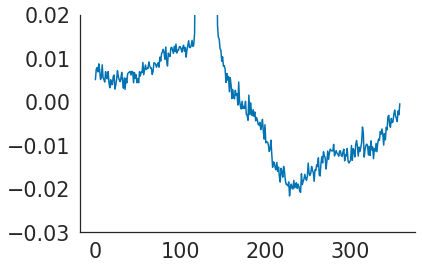

In [80]:
plt.plot(np.mean(fs, 0))
plt.ylim(-0.03, 0.02)